# 2. Modelo Prophet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pip install prophet

Se separan los datos en train y test como corresponde.

In [32]:
df_Kern_train = pd.read_csv('Kern_train.csv')
df_Kern_test = pd.read_csv('Kern_test.csv')

## 2.1. Modelo para ventas totales

Se genera un primer modelo cuya finalidad será predecir las ventas mensuales de la empresa farmacéutica a lo largo del año 2025.

In [4]:
df_Kern_train.head()

,Código,Denominacion,Ventas,Fecha,Año
0,658257,PARACETAMOL KERN 1GRX40 CO EFG,29,2020-01-01,2020
1,958413,DIAZEPAN PRODES 5 MG 30 COMP,20,2020-01-01,2020
2,658256,PARACETAMOL KERN 1GRX20 CO EFG,30,2020-01-01,2020
3,687626,PARACETAMOL KERN PHARMA 500 MG 20 C EFG,15,2020-01-01,2020
4,673058,SULPIRIDA KERN PHARMA 50 MG 30 CAPS EFG,10,2020-01-01,2020


Se preparan los datos para ser trabajados correctamente con Prophet.

In [5]:
df_prophet_total = df_Kern_train.groupby("Fecha")["Ventas"].sum().reset_index()
df_prophet_total.columns = ['ds', 'y']

In [6]:
df_prophet_total.head()

,ds,y
0,2020-01-01,886
1,2020-02-01,880
2,2020-03-01,845
3,2020-04-01,844
4,2020-05-01,846


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx_7g7j17/12g93t0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx_7g7j17/pbw5urjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90724', 'data', 'file=/tmp/tmpx_7g7j17/12g93t0_.json', 'init=/tmp/tmpx_7g7j17/pbw5urjd.json', 'output', 'file=/tmp/tmpx_7g7j17/prophet_model_4ld58pi/prophet_model-20250520174600.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:46:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages

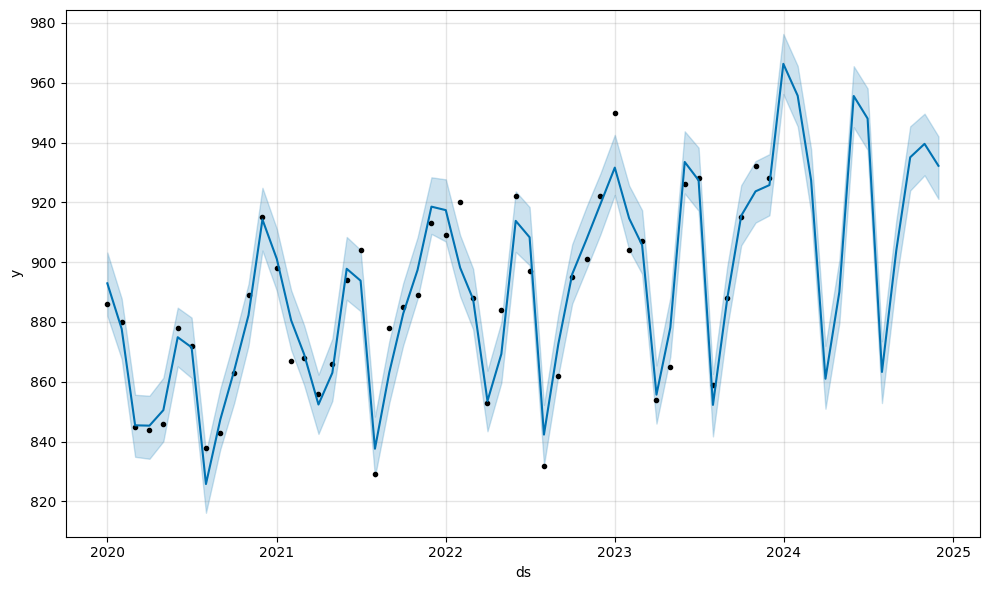

In [35]:
from prophet import Prophet

modelo_total = Prophet()
modelo_total.fit(df_prophet_total)

futuro_total = modelo_total.make_future_dataframe(periods=12, freq='M')
predicciones_total = modelo_total.predict(futuro_total)

fig = modelo_total.plot(predicciones_total)
plt.show()

## 2.2. Modelo para ventas por medicamento

El objetivo principal de este proyecto no es predecir las ventas anuales totales, sino las ventas mensuales de cada medicamento, con el fin de gestionar adecuadamente el inventario y no sufrir sobrestock.
Para ello, el modelo se va a centrar en aquellos medicamentos que tengan ventas en al menos 24 meses de los últimos cuatro años.

In [9]:
# Medicamentos con al menos 24 meses con ventas > 0
medicamentos_validos = []
for nombre in df_Kern_train['Denominacion'].unique():
    df_med = df_Kern_train[df_Kern_train["Denominacion"] == nombre]
    if (df_med["Ventas"] > 0).sum() >= 24:
        medicamentos_validos.append(nombre)

df_pred_med = pd.DataFrame()

# Predicciones para cada medicamento
for nombre in medicamentos_validos:
    df_med = df_Kern_train[df_Kern_train["Denominacion"] == nombre][["Fecha", "Ventas"]].copy()
    df_med = df_med.rename(columns={"Fecha": "ds", "Ventas": "y"})

    modelo_med = Prophet()
    modelo_med.fit(df_med)

    futuro_med = modelo_med.make_future_dataframe(periods=12, freq='M')
    pred_med = modelo_med.predict(futuro_med)

    pred_med = pred_med[["ds", "yhat"]].copy()
    pred_med["yhat"] = pred_med["yhat"].round().astype(int)
    pred_med["Denominacion"] = nombre

    df_pred_med = pd.concat([df_pred_med, pred_med], ignore_index=True)

# Se eliminan los espacios vacíos en los nombres
df_pred_med["Denominacion"]=df_pred_med["Denominacion"].str.strip()
# Se guarda el dataframe
df_pred_med.to_csv("Predicciones_Kern.csv", index=False)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx_7g7j17/gsc2_c2n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx_7g7j17/q83_ztun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65579', 'data', 'file=/tmp/tmpx_7g7j17/gsc2_c2n.json', 'init=/tmp/tmpx_7g7j17/q83_ztun.json', 'output', 'file=/tmp/tmpx_7g7j17/prophet_modelwe_s7_le/prophet_model-20250520150359.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:03:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:04:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages

### 2.2.1. Diazepan Prodes 5 MG 30 COMP


<Axes: title={'center': 'DIAZEPAN PRODES  5 MG 30 COMP'}, xlabel='ds'>

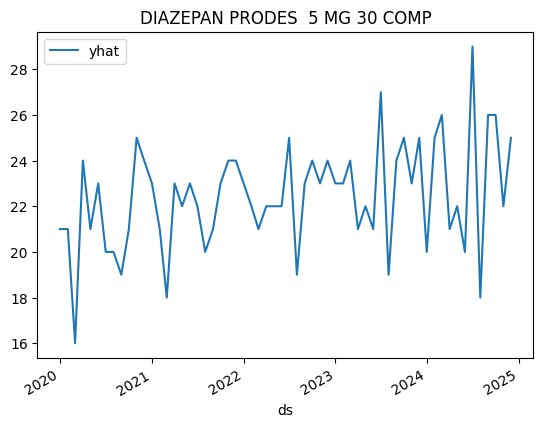

In [18]:
med = 'DIAZEPAN PRODES  5 MG 30 COMP'
df_pred_med[df_pred_med['Denominacion']==med][['ds','yhat']].set_index('ds').plot(title=med)

A simple vista parece que la predicción puede ser adecuada considerando el comportamiento de las ventas en los últimos años.
Cabe destacar que el modelo detecta un crecimiento en la pendiente de la gráfica a mediados de año, generando una caída brusca en las ventas.
A falta de evaluar el modelo con los datos de test, parece que predice de manera aceptable el modelo.

### 2.2.2. Paracetamol 1GR 40 COMP

<Axes: title={'center': 'PARACETAMOL KERN 1GRX40 CO EFG'}, xlabel='ds'>

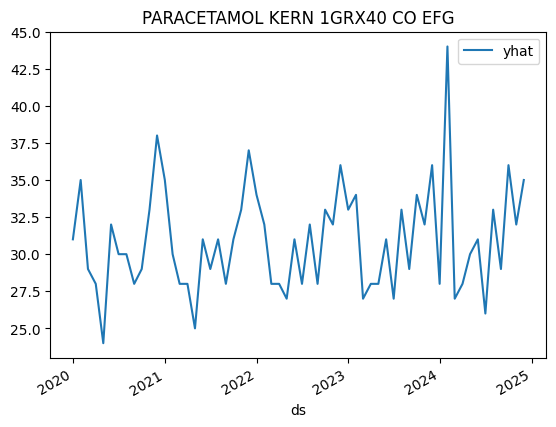

In [19]:
med = 'PARACETAMOL KERN 1GRX40 CO EFG'
df_pred_med[df_pred_med['Denominacion']==med][['ds','yhat']].set_index('ds').plot(title=med)

En esta ocasión sin embargo, el modelo no parece predecir con tanta exactitud.
De 2020 a 2024 las ventas mensuales aumentan en la mayoría de meses del año, no obstante, las ventas en los últimos meses del año decaen. Parece que el modelo no es capaz de observar correctamente este comportamiento, ya que refleja un crecimiento sin precedentes en la predicción de inicios del año 2025.

### 2.2.3. Metformina 1000 MG 30 COMP

<Axes: title={'center': 'METFORMINA KERN 1000 MG 30 COMP EFG'}, xlabel='ds'>

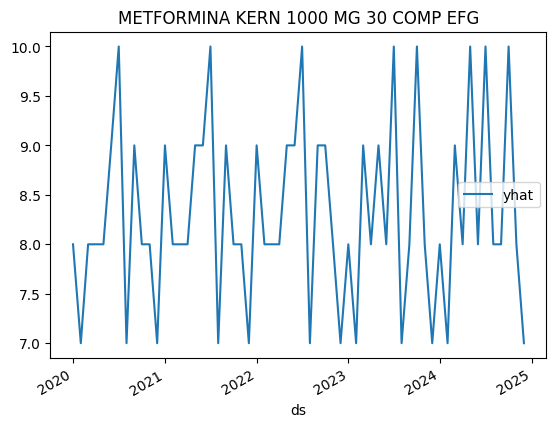

In [21]:
med = 'METFORMINA KERN 1000 MG 30 COMP EFG'
df_pred_med[df_pred_med['Denominacion']==med][['ds','yhat']].set_index('ds').plot(title=med)

Si observamos predicciones de medicamentos con menos unidades vendidas, parece que al modelo le resulta más sencillo realizar una predicción más acertada.

## 2.3. Evaluación de los modelos

### 2.3.1. Evaluación Modelo ventas totales

* Se prepara el dataset de test

In [44]:
df_Kern_test = df_Kern_test.groupby("Fecha")["Ventas"].sum().reset_index()
df_Kern_test.columns = ['ds', 'y']
df_Kern_test['ds'] = pd.to_datetime(df_Kern_test['ds'])
df_Kern_test.head()

,ds,y
0,2024-01-01,929
1,2024-02-01,949
2,2024-03-01,919
3,2024-04-01,886
4,2024-05-01,910


* Se prepara el dataframe de las predicciones

In [45]:
pred_total_2024 = predicciones_total[predicciones_total['ds'].dt.year == 2024][['ds', 'yhat']]
pred_total_2024['ds'] = pred_total_2024['ds'].dt.to_period('M').dt.to_timestamp()
pred_total_2024['yhat'] = pred_total_2024['yhat'].round().astype(int)
pred_total_2024['ds'] = pd.to_datetime(pred_total_2024['ds'])
pred_total_2024.head()

,ds,yhat
49,2024-01-01,956
50,2024-02-01,927
51,2024-03-01,861
52,2024-04-01,890
53,2024-05-01,956


* Evaluamos el modelo

In [46]:
evaluacion_total = df_Kern_test.merge(pred_total_2024, on='ds', how='inner')

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(evaluacion_total['y'], evaluacion_total['yhat'])
rmse = np.sqrt(mean_squared_error(evaluacion_total['y'], evaluacion_total['yhat']))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 34.82, RMSE: 41.47


Considerando el volumen de ventas (800-1000 unidades mensuales), podemos calificar los resultados de la evaluación del modelo como buenos.
En términos de error absoluto promedio, es aproximadamente de un 3.5% mensual.
En cuanto al error típico (RSME) está entre el 4-5%.
En términos generales el comportamiento del modelo es más que aceptable. No obstante, el hecho de que el RSME sea mayor que el MAE indica una posible flaqueza en las estacionalidades o meses atípicos.